# Importando Bibliotecas

In [ ]:
!pip install datasets transformers==4.28.0

Baseado no [artigo](https://medium.com/analytics-vidhya/text-classification-from-bag-of-words-to-bert-1e628a2dd4c9) de Anirban Sen

Dataset: [JTCC_Bag_Of_Words ](https://www.kaggle.com/code/anirbansen3027/jtcc-bag-of-words/notebook)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from statistics import mean

import string

#Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, confusion_matrix

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Pyrhotch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#To set precision to 3 decimals
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

# Explorando base de dados

O [conjunto de dados](https://huggingface.co/nickmuchi/finbert-tone-finetuned-finance-topic-classification/blob/main/pytorch_model.bin) de notícias financeiras do Twitter é um conjunto de dados em inglês que contém um corpus anotado de tweets relacionados a finanças. Cada registro da base contém o texto do twitte e seu respectivo rótulo.

In [ ]:
#Usando a biblioteca do Huugging Face
from datasets import load_dataset

dataset = load_dataset("zeroshot/twitter-financial-news-topic")

Visualização da estrutura e de um exemplo de texto do dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [ ]:
dataset["train"][100]['text']

'$ALLY - Ally Financial downgraded to In Line as delinquency rates rise  https://t.co/oWHXbO69wx'

In [ ]:
dataset["train"][100]['label']

0

O dataset possui 20 labels, são elas:

In [ ]:
topics = {
    "LABEL_0": "Analyst Update",
    "LABEL_1": "Fed | Central Banks",
    "LABEL_2": "Company | Product News",
    "LABEL_3": "Treasuries | Corporate Debt",
    "LABEL_4": "Dividend",
    "LABEL_5": "Earnings",
    "LABEL_6": "Energy | Oil",
    "LABEL_7": "Financials",
    "LABEL_8": "Currencies",
    "LABEL_9": "General News | Opinion",
    "LABEL_10": "Gold | Metals | Materials",
    "LABEL_11": "IPO",
    "LABEL_12": "Legal | Regulation",
    "LABEL_13": "M&A | Investments",
    "LABEL_14": "Macro",
    "LABEL_15": "Markets",
    "LABEL_16": "Politics",
    "LABEL_17": "Personnel Change",
    "LABEL_18": "Stock Commentary",
    "LABEL_19": "Stock Movement",
}


## Distribuição das classes (%) no dataset de treino

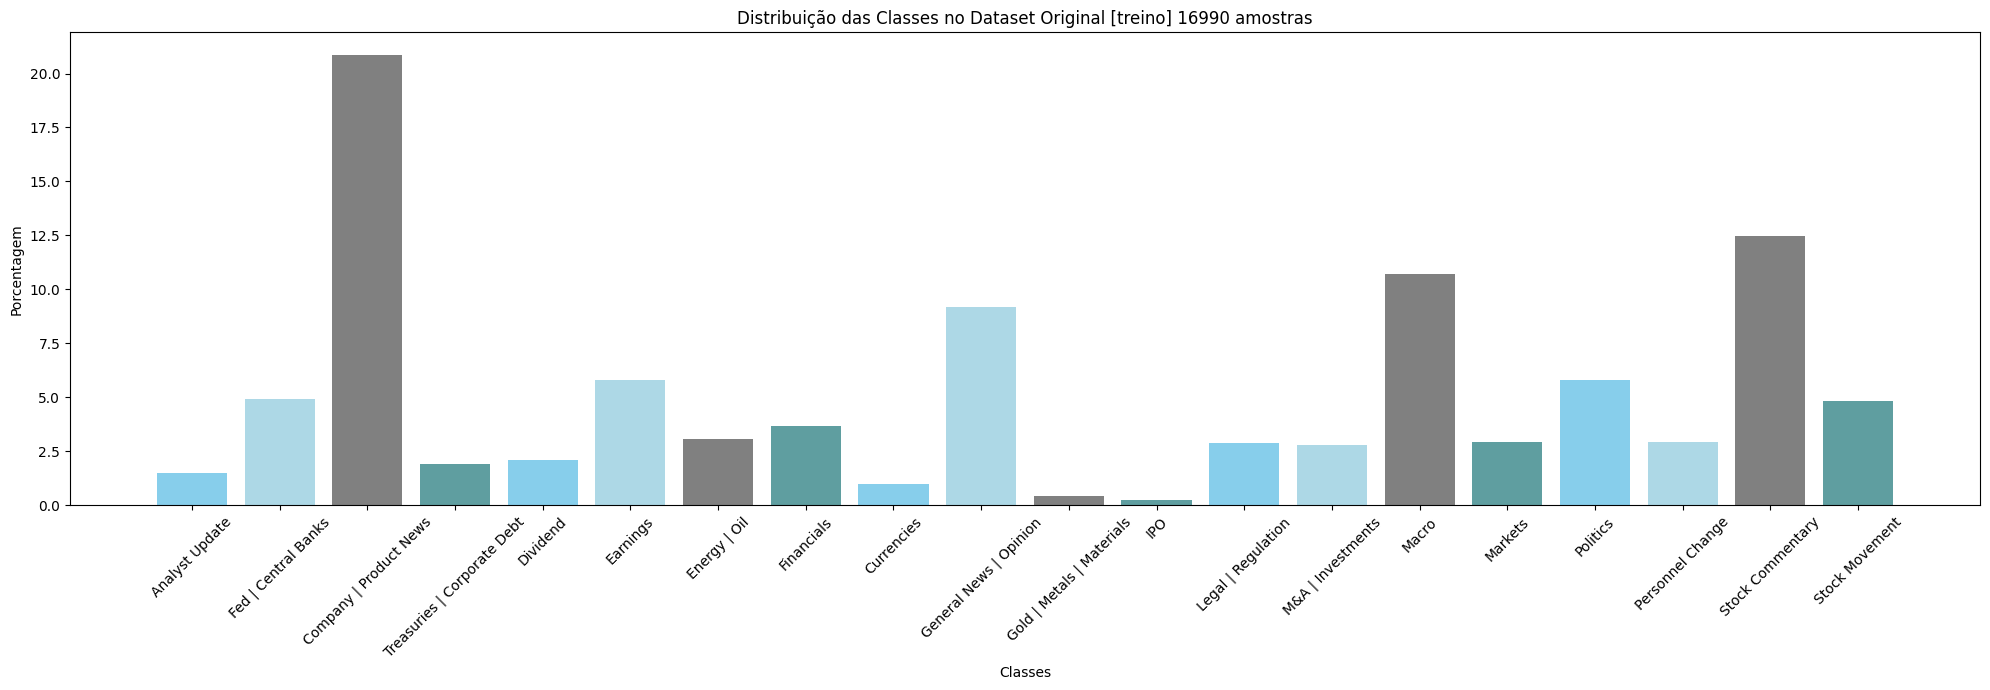

In [ ]:
total = len(dataset["train"]['label'])

#Número de registro para cada classe
analystUpdateLen = len([x for x in dataset["train"]['label'] if x == 0])
fedCentralBanksLen = len([x for x in dataset["train"]['label'] if x == 1])
companyProductNewsLen = len([x for x in dataset["train"]['label'] if x == 2])
treasuriesCorporateDebtLen = len([x for x in dataset["train"]['label'] if x == 3])
dividendLen = len([x for x in dataset["train"]['label'] if x == 4])
earningsLen = len([x for x in dataset["train"]['label'] if x == 5])
energyOilLen = len([x for x in dataset["train"]['label'] if x == 6])
financialsLen = len([x for x in dataset["train"]['label'] if x == 7])
currenciesLen = len([x for x in dataset["train"]['label'] if x == 8])
generalNewsOpinionLen = len([x for x in dataset["train"]['label'] if x == 9])
goldMetalsMaterialsLen = len([x for x in dataset["train"]['label'] if x == 10])
ipoLen = len([x for x in dataset["train"]['label'] if x == 11])
legalRegulationLen = len([x for x in dataset["train"]['label'] if x == 12])
maInvestmentsLen = len([x for x in dataset["train"]['label'] if x == 13])
macroLen = len([x for x in dataset["train"]['label'] if x == 14])
marketsLen = len([x for x in dataset["train"]['label'] if x == 15])
politicsLen = len([x for x in dataset["train"]['label'] if x == 16])
personnelChangeLen = len([x for x in dataset["train"]['label'] if x == 17])
stockCommentaryLen = len([x for x in dataset["train"]['label'] if x == 18])
stockMovementLen = len([x for x in dataset["train"]['label'] if x == 19])


import matplotlib.pyplot as plt

classes = ['Analyst Update', 'Fed | Central Banks', 'Company | Product News', 'Treasuries | Corporate Debt', 'Dividend', 'Earnings', 'Energy | Oil', 'Financials', 'Currencies', 'General News | Opinion', 'Gold | Metals | Materials', 'IPO', 'Legal | Regulation', 'M&A | Investments', 'Macro', 'Markets', 'Politics', 'Personnel Change', 'Stock Commentary', 'Stock Movement']

#porcentagens
contagens = [analystUpdateLen*100/total, fedCentralBanksLen*100/total, companyProductNewsLen*100/total, treasuriesCorporateDebtLen*100/total,
 dividendLen*100/total, earningsLen*100/total, energyOilLen*100/total, financialsLen*100/total, currenciesLen*100/total, generalNewsOpinionLen*100/total,
 goldMetalsMaterialsLen*100/total, ipoLen*100/total, legalRegulationLen*100/total, maInvestmentsLen*100/total, macroLen*100/total, marketsLen*100/total,
 politicsLen*100/total, personnelChangeLen*100/total, stockCommentaryLen*100/total, stockMovementLen*100/total]




# Cria um gráfico de barras
#sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 7))  # Define o tamanho do gráfico
plt.bar(classes, contagens, color=['skyblue', 'lightblue', 'grey', 'cadetblue'])  # Cria o gráfico de barras com as classes e contagens
plt.xlabel('Classes')  # Rótulo do eixo X
plt.ylabel('Porcentagem')  # Rótulo do eixo Y
plt.title('Distribuição das Classes no Dataset Original [treino] ' + str(len(dataset["train"]['label'])) + ' amostras')  # Título do gráfico

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotação dos rótulos das classes para melhor visualização
plt.tight_layout()  # Garante que os rótulos e barras não fiquem cortados
plt.show()



## Distribuição das classes (%) no dataset de teste

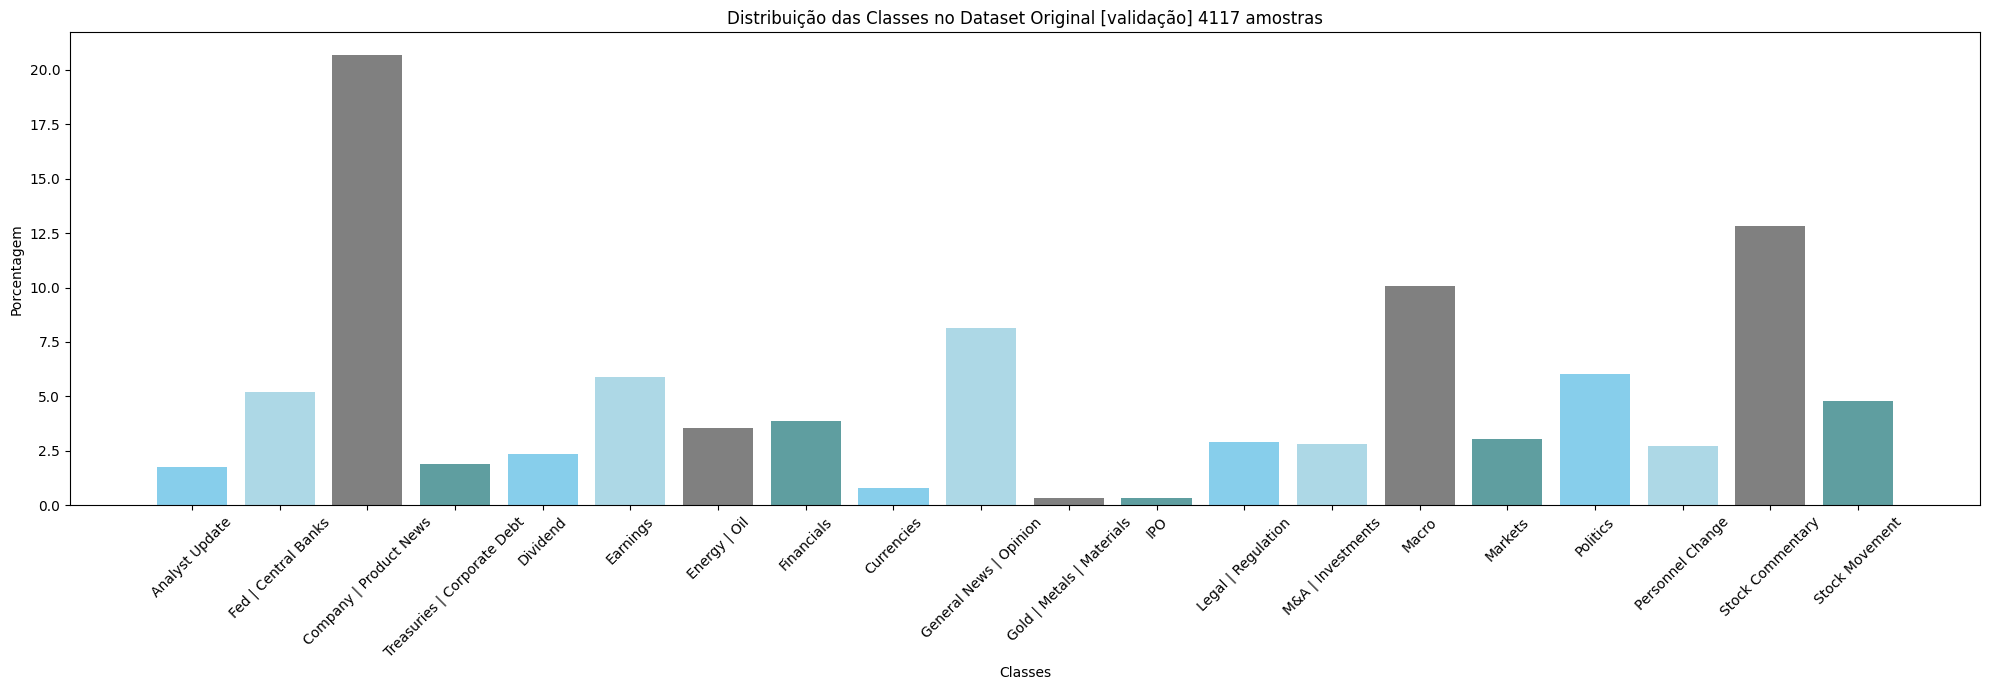

In [ ]:
total = len(dataset["validation"]['label'])

#Número de registro para cada classe
analystUpdateLen = len([x for x in dataset["validation"]['label'] if x == 0])
fedCentralBanksLen = len([x for x in dataset["validation"]['label'] if x == 1])
companyProductNewsLen = len([x for x in dataset["validation"]['label'] if x == 2])
treasuriesCorporateDebtLen = len([x for x in dataset["validation"]['label'] if x == 3])
dividendLen = len([x for x in dataset["validation"]['label'] if x == 4])
earningsLen = len([x for x in dataset["validation"]['label'] if x == 5])
energyOilLen = len([x for x in dataset["validation"]['label'] if x == 6])
financialsLen = len([x for x in dataset["validation"]['label'] if x == 7])
currenciesLen = len([x for x in dataset["validation"]['label'] if x == 8])
generalNewsOpinionLen = len([x for x in dataset["validation"]['label'] if x == 9])
goldMetalsMaterialsLen = len([x for x in dataset["validation"]['label'] if x == 10])
ipoLen = len([x for x in dataset["validation"]['label'] if x == 11])
legalRegulationLen = len([x for x in dataset["validation"]['label'] if x == 12])
maInvestmentsLen = len([x for x in dataset["validation"]['label'] if x == 13])
macroLen = len([x for x in dataset["validation"]['label'] if x == 14])
marketsLen = len([x for x in dataset["validation"]['label'] if x == 15])
politicsLen = len([x for x in dataset["validation"]['label'] if x == 16])
personnelChangeLen = len([x for x in dataset["validation"]['label'] if x == 17])
stockCommentaryLen = len([x for x in dataset["validation"]['label'] if x == 18])
stockMovementLen = len([x for x in dataset["validation"]['label'] if x == 19])


import matplotlib.pyplot as plt

classes = ['Analyst Update', 'Fed | Central Banks', 'Company | Product News', 'Treasuries | Corporate Debt', 'Dividend', 'Earnings', 'Energy | Oil', 'Financials', 'Currencies', 'General News | Opinion', 'Gold | Metals | Materials', 'IPO', 'Legal | Regulation', 'M&A | Investments', 'Macro', 'Markets', 'Politics', 'Personnel Change', 'Stock Commentary', 'Stock Movement']

#porcentagens
contagens = [analystUpdateLen*100/total, fedCentralBanksLen*100/total, companyProductNewsLen*100/total, treasuriesCorporateDebtLen*100/total,
 dividendLen*100/total, earningsLen*100/total, energyOilLen*100/total, financialsLen*100/total, currenciesLen*100/total, generalNewsOpinionLen*100/total,
 goldMetalsMaterialsLen*100/total, ipoLen*100/total, legalRegulationLen*100/total, maInvestmentsLen*100/total, macroLen*100/total, marketsLen*100/total,
 politicsLen*100/total, personnelChangeLen*100/total, stockCommentaryLen*100/total, stockMovementLen*100/total]



# Cria um gráfico de barras
#sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 7))  # Define o tamanho do gráfico
plt.bar(classes, contagens, color=['skyblue', 'lightblue', 'grey', 'cadetblue'])  # Cria o gráfico de barras com as classes e contagens
plt.xlabel('Classes')  # Rótulo do eixo X
plt.ylabel('Porcentagem')  # Rótulo do eixo Y
plt.title('Distribuição das Classes no Dataset Original [validação] ' + str(total) + ' amostras')  # Título do gráfico

# Mostra o gráfico
plt.xticks(rotation=45)  # Rotação dos rótulos das classes para melhor visualização
plt.tight_layout()  # Garante que os rótulos e barras não fiquem cortados
plt.show()



# Implementando o modelo

In [ ]:
# Importando stop words como in, the, of para que possam ser removidas dos textos
# pois essas palavras não ajudam na determinação das classes
stop_words = _stop_words.ENGLISH_STOP_WORDS
# Função para limpeza/preprocessamento básico de textos
def clean(doc):
    # Remoção de sinais de pontuação (.,/\][{} etc) e números
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Remoção de stop words
    doc = " ".join([token for token in doc.split() if token not in stop_words])
    return doc.lower()


Creating a Bag of Words vector

In [ ]:
vect = CountVectorizer(max_features= 5000, preprocessor=clean)
X_train_dtm = vect.fit_transform(dataset['train']['text'])
X_val_dtm = vect.transform(dataset['validation']['text'])

print(X_train_dtm.shape, X_val_dtm.shape)

(16990, 5000) (4117, 5000)


In [ ]:
pd.DataFrame(X_train_dtm.A[:5], columns = vect.get_feature_names_out())

,aa,aal,aapl,ab,abandon,abandoned,abb,abbott,abbv,abbvie,...,yum,yy,zahawi,zealand,zelenskiy,zendesk,zero,zew,zimbabwe,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset["validation"]['label'][0]

0

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [ ]:

new_dataset = {
    "train": {
        "text": dataset['train']["text"],
        "label": [topics[f'LABEL_{label}'] if label in range(20) else label for label in dataset["train"]['label']],
    },
    "validation": {
        "text": dataset['validation']["text"],
        "label": [topics[f'LABEL_{label}'] if label in range(20) else label for label in dataset["validation"]['label']],
    },
}





In [ ]:
# One-hot encoding a single column
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

In [ ]:
array = np. array(new_dataset['train']['label'])
dfTrainLabel = pd. DataFrame(array)
array = np. array(new_dataset['validation']['label'])
dfValLabel = pd. DataFrame(array)
array = np. array(new_dataset['validation']['text'])
dfValText = pd. DataFrame(array)
array = np. array(new_dataset['train']['text'])
dfTrainText = pd. DataFrame(array)

In [ ]:
ohe = OneHotEncoder()
transformedTrain = ohe.fit_transform(dfTrainLabel[[0]])
print(transformedTrain.toarray())
transformedVal = ohe.fit_transform(dfValLabel[[0]])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
ohe.categories_

[array(['Analyst Update', 'Company | Product News', 'Currencies',
        'Dividend', 'Earnings', 'Energy | Oil', 'Fed | Central Banks',
        'Financials', 'General News | Opinion',
        'Gold | Metals | Materials', 'IPO', 'Legal | Regulation',
        'M&A | Investments', 'Macro', 'Markets', 'Personnel Change',
        'Politics', 'Stock Commentary', 'Stock Movement',
        'Treasuries | Corporate Debt'], dtype=object)]

In [ ]:
#Initializing and fitting models on Training Data
#Naive Bayes Model
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, transformedTrain.toarray())
#Logistic Regression Model (As we have unbalanced dataset, we use class_weight which will use inverse
#of counts of that class. It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1)
lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(X_train_dtm, transformedTrain.toarray())

In [ ]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def calculate_roc_auc(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [ ]:
#Creating an empty list of results
results = []
#Making predictions from all the trained models and measure performance for each
for model in [nb,lr]:
    #Extracting name of the model
    est = type(model.estimator).__name__
    #Actual output variables
    y_vals = transformedVal.toarray()
    #Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_val_dtm))[:,:,1])
    #Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals,y_preds))
    #Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])

#Output the results as a table
pd.DataFrame(results, columns = ["Model","Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.95
1,LogisticRegression,0.98


In [ ]:
dfValLabel[ohe.categories_[0]] = transformedVal.toarray()
dfValLabel.drop(0,
  axis='columns', inplace=True)


In [ ]:
dfValText.shape

(4117, 1)

In [ ]:
# Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(dfValText, dfValLabel, left_index= True, right_index=True)
#Transform the test dataset as well based on Bag of Words/ Count Vectorizer as the Logistic model would
#expect the same
X_test_dtm = vect.transform(df_test[0])
#Use the Logistic Regression model to output probabilities and take the probability for class 1
y_preds = np.transpose(np.array(lr.predict_proba(X_test_dtm))[:,:,1])
#Assign the predictions by the model in the final test dataset
df_test[classes] = y_preds
#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop([0], axis = 1, inplace = True)
#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission.csv", index = False)

In [ ]:
Wclasses = classes
Wclasses.insert(0, 'Word')

In [ ]:
#Assigning the feature names to an empty list
feat_impts = [vect.get_feature_names_out()]
#For all the models save the feature importances in the list.estimators_ would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())
#Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), columns = Wclasses)
#Converting Feature Importance Columns from string to float
classes.pop(0)
df_feats_impts[classes] = df_feats_impts[classes].astype("float32")
df_feats_impts.head()

,Word,Analyst Update,Fed | Central Banks,Company | Product News,Treasuries | Corporate Debt,Dividend,Earnings,Energy | Oil,Financials,Currencies,...,Gold | Metals | Materials,IPO,Legal | Regulation,M&A | Investments,Macro,Markets,Politics,Personnel Change,Stock Commentary,Stock Movement
0,aa,1.30,-0.19,-0.17,-0.00,-0.18,-0.03,-0.05,-0.44,-0.16,...,-0.00,-0.03,-0.03,-0.38,-0.50,-0.02,-0.05,0.26,-0.16,-0.14
1,aal,-0.36,0.06,-0.04,-0.02,0.14,-0.42,-0.08,-0.18,-0.52,...,-0.01,-0.06,-0.13,-0.45,-0.04,-0.36,-0.09,1.11,0.53,-0.06
2,aapl,0.81,-0.86,-0.11,-0.07,-0.25,-0.57,-0.34,-0.41,-1.31,...,-0.05,-0.22,-0.38,-1.02,-0.38,-0.20,-0.25,2.06,0.35,-0.42
3,ab,-0.07,-0.27,-0.04,-0.02,0.01,-0.05,-0.06,0.62,-0.21,...,-0.03,-0.09,-0.09,-0.15,-0.19,-0.10,-0.06,-0.45,-0.20,-0.08
4,abandon,-0.12,0.61,-0.01,-0.00,-0.02,-0.02,0.13,-0.03,-0.17,...,-0.01,-0.31,-0.28,-0.25,-0.02,-0.00,-0.07,0.15,-0.24,-0.05


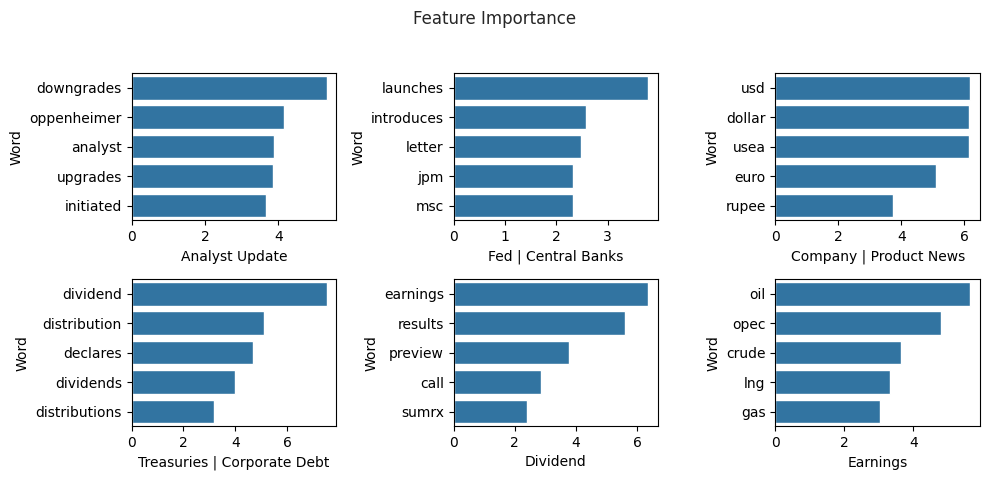

In [ ]:
#Creating Individual Feature Importance table by sorting on specific Analyst Update-type column and selecting top 5 Words
AnalystUpdate_fi = df_feats_impts[["Word","Analyst Update"]].sort_values(by = "Analyst Update", ascending = False).head()
FedCentralBanksUpdate_fi = df_feats_impts[["Word","Fed | Central Banks"]].sort_values(by = "Fed | Central Banks", ascending = False).head()
CompanyProductNews_fi = df_feats_impts[["Word","Company | Product News"]].sort_values(by = "Company | Product News", ascending = False).head()
TreasuriesCorporateDebt_fi = df_feats_impts[["Word","Treasuries | Corporate Debt"]].sort_values(by = "Treasuries | Corporate Debt", ascending = False).head()
Dividend_fi = df_feats_impts[["Word","Dividend"]].sort_values(by = "Dividend", ascending = False).head()
Earnings_fi = df_feats_impts[["Word","Earnings"]].sort_values(by = "Earnings", ascending = False).head()

#Plotting top 5 Words based on coefficient values from the LR model
fig,(ax1, ax2) =  plt.subplots(2,3,figsize=(10,5))
sns.set_style("darkgrid")
sns.barplot(x = "Analyst Update", y = "Word", ax = ax1[0], data = AnalystUpdate_fi)
sns.barplot(x = "Fed | Central Banks", y = "Word", ax = ax1[1], data = FedCentralBanksUpdate_fi)
sns.barplot(x = "Company | Product News", y = "Word", ax = ax1[2], data = CompanyProductNews_fi)
sns.barplot(x = "Treasuries | Corporate Debt", y = "Word", ax = ax2[0], data = TreasuriesCorporateDebt_fi)
sns.barplot(x = "Dividend", y = "Word", ax = ax2[1], data = Dividend_fi)
sns.barplot(x = "Earnings", y = "Word", ax = ax2[2], data = Earnings_fi)
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()